# Convnet Architecure Patterns


## Residual Connections

### Case where the tagret block changes the number of output filters

In [1]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])
x


<KerasTensor: shape=(None, 30, 30, 64) dtype=float32 (created by layer 'add')>

### Case where the target block includes a max pooling layer

In [2]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPool2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])
x

<KerasTensor: shape=(None, 15, 15, 64) dtype=float32 (created by layer 'add_1')>

In [3]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1.0/255)(inputs)

def residual_blocks(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPool2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_blocks(x, 32, True)
x = residual_blocks(x, 64, True)
x = residual_blocks(x, 128, False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   896         rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_6[0][0]                   
______________________________________________________________________________________________

## Batch Normalization 

### How NOT to use batch normalization

In [5]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs) # Here we acivate before the normalization, this is NOT the recommended way
x = layers.BatchNormalization()(x)
x

<KerasTensor: shape=(None, 30, 30, 32) dtype=float32 (created by layer 'batch_normalization')>

### How to use batch normalization: the activation comes last

In [6]:
x = layers.Conv2D(32, 3, use_bias=False)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x

<KerasTensor: shape=(None, 30, 30, 32) dtype=float32 (created by layer 'activation')>

## Depthwise separable convolutions

In [7]:
import kagglehub

kagglehub.login()


In [8]:
import zipfile

download_path = kagglehub.competition_download("dogs-vs-cats")

with zipfile.ZipFile(download_path + "/train.zip", "r") as zip_ref:
    zip_ref.extractall(".")

In [9]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    # First check if original directory exists
    if not original_dir.exists():
        raise FileNotFoundError(f"Original directory {original_dir} not found")
    
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        
        # Remove directory if it already exists to avoid conflicts
        if dir.exists():
            shutil.rmtree(dir)
            
        # Create directory and its parents
        os.makedirs(dir, exist_ok=True)
        
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_dir / fname
            dst = dir / fname
            if not src.exists():
                print(f"Warning: Source file {src} not found")
                continue
            shutil.copyfile(src=src, dst=dst)

# Create base directory if it doesn't exist
if new_base_dir.exists():
    shutil.rmtree(new_base_dir)
os.makedirs(new_base_dir)

try:
    make_subset("train", start_index=0, end_index=1000)
    make_subset("validation", start_index=1000, end_index=1500)
    make_subset("test", start_index=1500, end_index=2500)

    batch_size = 64
    image_size = (180, 180)
    
    train_dataset = image_dataset_from_directory(
        new_base_dir / "train",
        image_size=image_size,
        batch_size=batch_size,
        seed=42  # Add seed for reproducibility
    )
    validation_dataset = image_dataset_from_directory(
        new_base_dir / "validation",
        image_size=image_size,
        batch_size=batch_size,
        seed=42
    )
    test_dataset = image_dataset_from_directory(
        new_base_dir / "test",
        image_size=image_size,
        batch_size=batch_size,
        seed=42
    )
except Exception as e:
    print(f"An error occurred: {str(e)}")

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
import tensorflow as tf
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
]

def data_augmentation(images, targets):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images, targets


augmented_train_dataset = train_dataset.map(
    data_augmentation, num_parallel_calls=tf.data.AUTOTUNE
)

In [11]:
from tensorflow import keras

inputs  = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])
    
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [13]:
history = model.fit(
    augmented_train_dataset,
    epochs=100,
    validation_data=validation_dataset,
)

2025-06-05 01:56:31.238512: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2025-06-05 01:56:31.239685: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
32/32 [==============================] - 58s 2s/step - loss: 0.6822 - accuracy: 0.5715 - val_loss: 0.7041 - val_accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 60s 2s/step - loss: 0.6624 - accuracy: 0.5980 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 65s 2s/step - loss: 0.6380 - accuracy: 0.6200 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 67s 2s/step - loss: 0.6162 - accuracy: 0.6540 - val_loss: 0.6998 - val_accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 67s 2s/step - loss: 0.6133 - accuracy: 0.6550 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 63s 2s/step - loss: 0.5825 - accuracy: 0.6955 - val_loss: 0.7035 - val_accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 65s 2s/step - loss: 0.5640 - accuracy: 0.7090 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 8/100
3

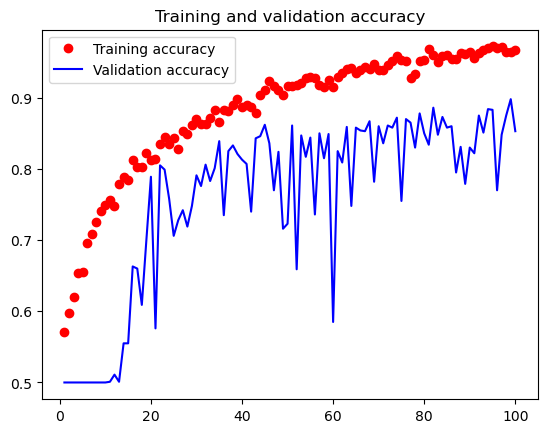

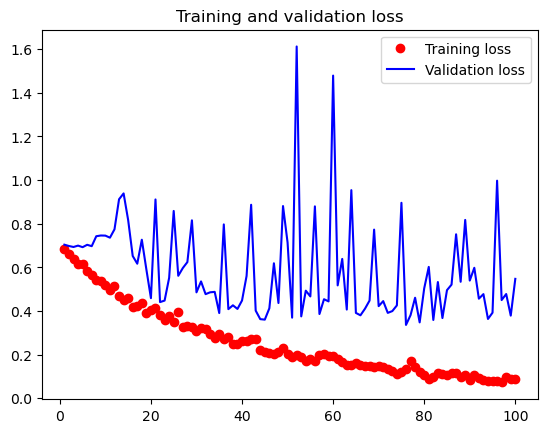

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()